[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

- extended to cover also Oxygen-18 (in addition to Deuterium)
- assuming equal ventilation coefficients for all isotopologues

notes:
- intriguing sign of the rhs in eq. (8) in the paper (gives drop mass increase for 0<S<1) - hence using an "outward mass flux" in the derivation below

In [11]:
# TODO #1307 - x2 for Deuterium when using ratios?!
# TODO #1307 - smoke test
# TODO #1307 - move new formulae into physics 
# TODO #1307 - text labels on the plot
# TODO #1307 - contour plot of dR/dt (from formulae) with zero isolina matching the paper fig?

In [12]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM')

In [13]:
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae
from PySDM.physics.constants import si, PER_MILLE, T0
from matplotlib import pyplot
import numpy as np

VENTILATION_COEFFICIENT_RATIO = 1

FORMULAE = Formulae(isotope_equilibrium_fractionation_factors='HoritaAndWesolowski1994')
CONST = FORMULAE.constants

#### derivations:

- Maxwell-Mason equation:
$$a\frac{da}{dt} = f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat od condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $p_\text{vs}$ saturation vapour pressure.

- expressed in terms of **outward mass flux** (hence "negative surface") with mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{-surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{-4 \pi a}
= -\rho_\text{w} a \frac{da}{dt}
$$

- introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$ and approximating $S\approx 1$:

$$
\frac{dm}{dt} 
= -4 \pi a f \frac{S - 1}{\frac{1}{\Psi\rho_\text{s}} + \frac{l_\text{v}}{KT}\left( \frac{l_\text{v}}{R_\text{v}T} - 1\right)}
= -4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + \frac{\Psi \rho_\text{s}l_\text{v}}{KT} \left(\frac{l_\text{v}}{R_\text{v}T}-1\right)}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
= -4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \left(1-\frac{R_\text{v}T}{l_\text{v}}\right)}
\approx -4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b}
$$

In [23]:
print(f"the parenthesis in the denominator equals (at the triple point): {1 - CONST.Rv * CONST.T_tri / CONST.l_tri:.3g}")

the parenthesis in the denominator equals (at the triple point): 0.95


In [15]:
class AmbientAir:
    def __init__(self, *, isotope, delta_v, temperature, b_multiplier):
        self.vsmow_ratio = getattr(CONST, f'VSMOW_R_{isotope}')
        self.iso_ratio_v = FORMULAE.trivia.isotopic_delta_2_ratio(delta_v, self.vsmow_ratio)
        self.b = b_multiplier * FORMULAE.latent_heat.lv(temperature)**2 * CONST.D0 / CONST.K0 / CONST.Rv / temperature**2
        self.alpha_w = getattr(
            FORMULAE.isotope_equilibrium_fractionation_factors,
            f'alpha_l_{isotope}'
        )(temperature)

        self.diff_coef_ratio = getattr(CONST, f'D_light_H2O__over__D_{isotope}_enriched')        
        
class NoFractionationSaturation:
    def __init__(self, *, ambient_air: AmbientAir, liquid: bool = False, vapour: bool = False):
        assert liquid != vapour
        self.liquid = liquid
        self.ambient_air = ambient_air
        
    def __call__(self, iso_ratio_r):
        iso_ratio_x = iso_ratio_r if self.liquid else self.ambient_air.iso_ratio_v
        diff_rat = VENTILATION_COEFFICIENT_RATIO * self.ambient_air.diff_coef_ratio
        return (
            diff_rat * iso_ratio_x 
            - iso_ratio_r / self.ambient_air.alpha_w
        ) / (
            diff_rat * iso_ratio_x 
            - (1 + self.ambient_air.b) * self.ambient_air.iso_ratio_v
            + self.ambient_air.b * iso_ratio_r / self.ambient_air.alpha_w
        )

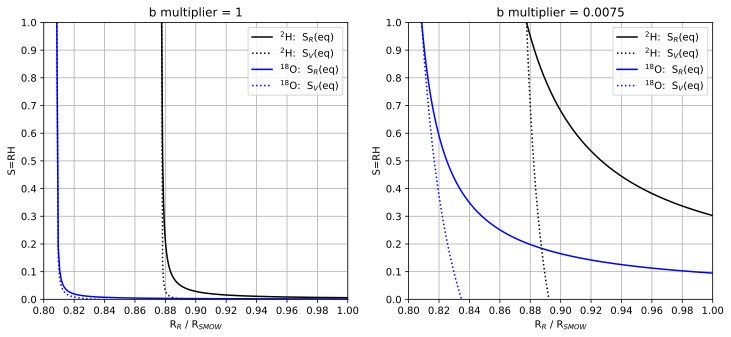

HTML(value="<a href='./fig_2.pdf' target='_blank'>./fig_2.pdf</a><br>")

In [22]:
fig, axs = pyplot.subplots(1, 2, figsize=(12, 5))
for plot_index, b_multiplier in enumerate((1, .0075)):
    axs[plot_index].set_title(f"b multiplier = {b_multiplier:.3g}")
    for iso, color in {'2H': 'black', '18O': 'blue'}.items():
        ambient_air = AmbientAir(
            isotope=iso,
            delta_v= -200 * PER_MILLE,
            temperature= T0 + 10 * si.K,
            b_multiplier=b_multiplier
        )
        eq_22 = NoFractionationSaturation(ambient_air=ambient_air, liquid=True)
        eq_23 = NoFractionationSaturation(ambient_air=ambient_air, vapour=True)
        
        x = np.linspace(ambient_air.alpha_w * ambient_air.iso_ratio_v / ambient_air.vsmow_ratio, 1, 200)
        isolbl = f'$^{{{iso[:-1]}}}${iso[-1:]}: '
        axs[plot_index].plot(x, eq_22(x * ambient_air.vsmow_ratio), label=f'{isolbl} S$_R$(eq)', color=color)
        axs[plot_index].plot(x, eq_23(x * ambient_air.vsmow_ratio), label=f'{isolbl} S$_V$(eq)', color=color, linestyle=':')
        
        axs[plot_index].set_xlim(.8, 1)
        axs[plot_index].set_xticks(np.linspace(.8, 1, 11))
        axs[plot_index].set_xlabel('R$_R$ / R$_{SMOW}$')
        
        axs[plot_index].set_ylim(0, 1)
        axs[plot_index].set_yticks(np.linspace(0, 1, 11))
        axs[plot_index].set_ylabel('S=RH')
    
        axs[plot_index].grid(visible=True, axis='both')
        axs[plot_index].legend()

show_plot('fig_2.pdf')